If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")


CPU times: user 20 s, sys: 2min 16s, total: 2min 36s
Wall time: 2min 1s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with KCNE1 sequences 

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

85
The number of hits is 97
The total aligned regions is 97


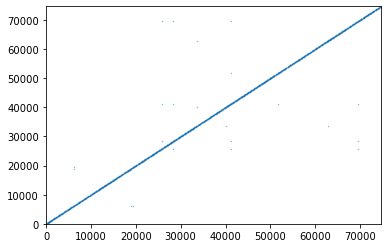

In [7]:
ref_file_name, gene_chr, gene_s, gene_e = 'hg19_tagged.fa', 'chr1_hg19', 35818987, 35883613
padding = 5000

#get a segment of a reference
gene_seq0 = ref_db.get_sub_seq(ref_file_name, gene_chr, gene_s-padding, gene_e+padding)

gene_seq = gene_seq0

#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(sdb, gene_seq0, merge_range_tol=10000)


aln_range = aln_range0

x, y = pgrtk.get_shmmr_dots(gene_seq0, gene_seq0, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(gene_seq))
plt.ylim(0,len(gene_seq))


print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)


In [8]:

gene_seq0 = pgrtk.rc_byte_seq(gene_seq0)

#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(sdb, gene_seq0, merge_range_tol=10000)

aln_range = aln_range0
 

#print("The number of hits form q1 is", len(aln_range0))
#print("The number of hits form q2 is", len(aln_range1))
print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 97
The total aligned regions is 97


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG03540#1#JAGYVY010000035.1', 'HG03540.paternal.f1_assembly_v2_genbank.fa', 42152478) target region 25577021 - 25650405 len: 73384
('NA19240#1#JAHEOM010000087.1', 'NA19240.paternal.f1_assembly_v2_genbank.fa', 27226532) target region 10654975 - 10728334 len: 73359
('NA20129#2#JAHEPD010000012.1', 'NA20129.maternal.f1_assembly_v2_genbank.fa', 92880013) target region 67912883 - 67986240 len: 73357
('HG03516#2#JAGYYS010000032.1', 'HG03516.maternal.f1_assembly_v2_genbank.fa', 46468975) target region 29889665 - 29963032 len: 73367
('HG01243#2#JAHEOX010000022.1', 'HG01243.maternal.f1_assembly_v2_genbank.fa', 35122195) target region 25671408 - 25743982 len: 72574
('HG01952#2#JAHAMD010000057.1', 'HG01952.maternal.f1_assembly_v2_genbank.fa', 42288850) target region 16504531 - 16577535 len: 73004
('HG00673#1#JAHBBZ010000033.1', 'HG00673.paternal.f1_assembly_v2_genbank.fa', 42227865) target region 25652939 - 25725104 len: 72165
('NA19240#2#JAHEOL010000112.1', 'NA19240.maternal.f1_assembly_v2_genb

Text(0, 0.5, 'count')

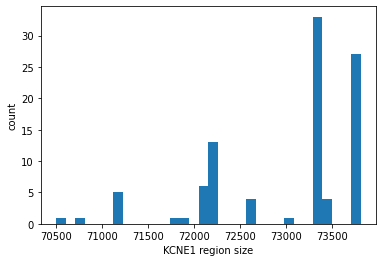

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("KCNE1 region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots

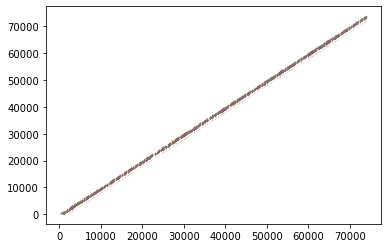

In [11]:
seq_list = []
i = 0
seq_info = sdb.seq_info.copy()
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
   
    for rgn in rgns:
        b, e, length, orientation, aln = rgn

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
       
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append((i, "{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        x, y = pgrtk.get_shmmr_dots(gene_seq0, seq, 80, 56, 4, 1)
        plt.plot(x, y, ".", markersize=0.1)
        i += 1



## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
 
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=24, k=24, r=4, min_span=1)

In [14]:
len(new_sdb.seq_info)

97

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, gene_seq0, merge_range_tol=10000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 97
The total aligned regions is 97


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 97


Text(0, 0.5, 'count')

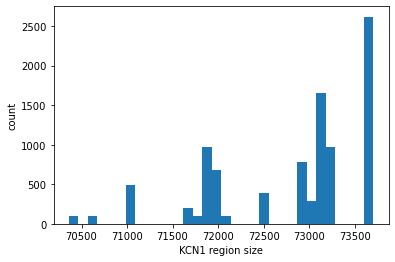

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("KCN1 region size")
plt.ylabel("count")

In [19]:
f0 = open("/results/KCNE1_seq.fa", "w")
for sid in aln_range:
    rgns = aln_range[sid]
    c, s, _ = new_sdb.seq_info[sid]
    print(c, s)
    count = 0
    for rgn in rgns:
        b, e, l, orientation, alns = rgn
        seq = new_sdb.get_sub_seq(s, c, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
        
        print(">{}_{}_{} {}".format(c, b, e, s), file=f0)
        print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

HG03540#1#JAGYVY010000035.1_25577021_25650405_1 Memory
HG02148#2#JAHAMF010000063.1_23364926_23437076_1 Memory
HG02055#2#JAHEPJ010000074.1_9378003_9451409_0 Memory
HG02818#2#JAHEOR010000074.1_9381656_9452866_0 Memory
HG00741#1#JAHALY010000034.1_16501927_16575729_0 Memory
HG00733#2#JAHEPP010000006.1_3549321_3621898_1 Memory
HG01891#2#JAGYVN010000019.1_16511420_16584794_0 Memory
HG01928#1#JAGYVQ010000014.1_16499133_16571285_0 Memory
HG01243#1#JAHEOY010000069.1_10578482_10650656_1 Memory
HG03540#2#JAGYVX010000025.1_25815925_25888076_1 Memory
HG005#2#JAHEPN010000029.1_16507321_16581112_0 Memory
HG02572#1#JAHAOW010000300.1_1276005_1348176_0 Memory
NA18906#1#JAHEOO010000054.1_70561459_70635262_0 Memory
HG002#1#JAHKSE010000012.1_85257992_85331331_0 Memory
NA19240#2#JAHEOL010000112.1_25735087_25805807_1 Memory
HG02559#2#JAGYVJ010000027.1_33667939_33741301_1 Memory
NA19240#1#JAHEOM010000087.1_10654975_10728334_1 Memory
HG02818#1#JAHEOS010000052.1_25907219_25980581_1 Memory
NA20129#1#JAHEPE010000

## Construct the genome graphs

In [20]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [21]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            v = w
    return G
    

In [22]:
for r in range(1,13):
    w=128; k=32;
    name="KCNE1"
    G = get_graph(seq_list, w=w, k=k, r=r, highlite=83)
    nx_pydot.write_dot(G, f"{name}-{w}-{k}-{r}.dot")
    ## for this version of graphviz, we need to create PDF to get the bounding box right
    os.system(f"""dot -Tpdf {name}-{w}-{k}-{r}.dot -x -Grankdir=LR -Gsize=64,64 \
    -Nfixedsize=true -Nwidth=.5 -Nheight=.5 -Nlabel="" > {name}-{w}-{k}-{r}.pdf""")
    os.system(f"""pdf2svg {name}-{w}-{k}-{r}.pdf {name}-{w}-{k}-{r}.svg""")

In [23]:
!ls /results/*.svg

/results/KCNE1-128-32-10.svg  /results/KCNE1-128-32-4.svg
/results/KCNE1-128-32-11.svg  /results/KCNE1-128-32-5.svg
/results/KCNE1-128-32-12.svg  /results/KCNE1-128-32-6.svg
/results/KCNE1-128-32-1.svg   /results/KCNE1-128-32-7.svg
/results/KCNE1-128-32-2.svg   /results/KCNE1-128-32-8.svg
/results/KCNE1-128-32-3.svg   /results/KCNE1-128-32-9.svg


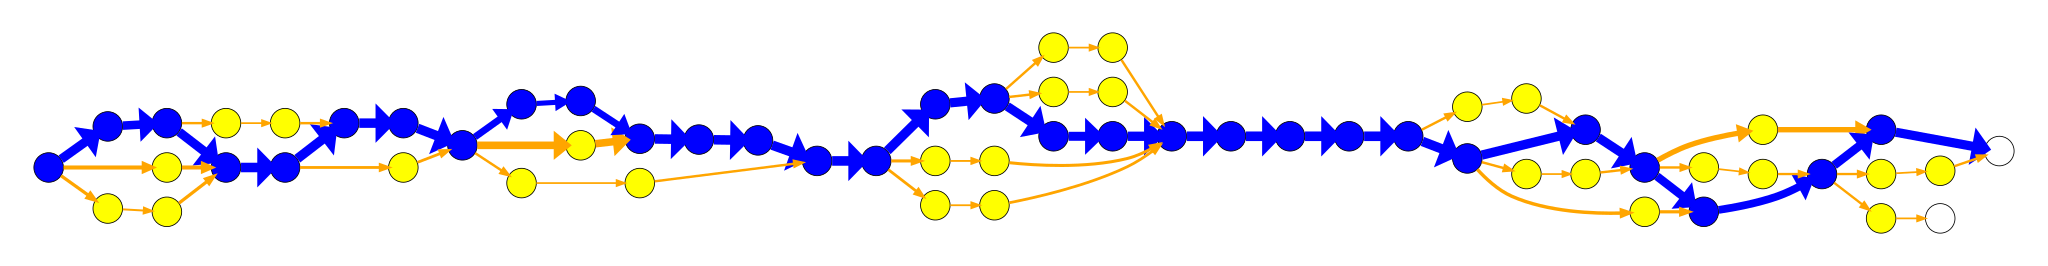

In [24]:
SVG("/results/KCNE1-128-32-12.svg")

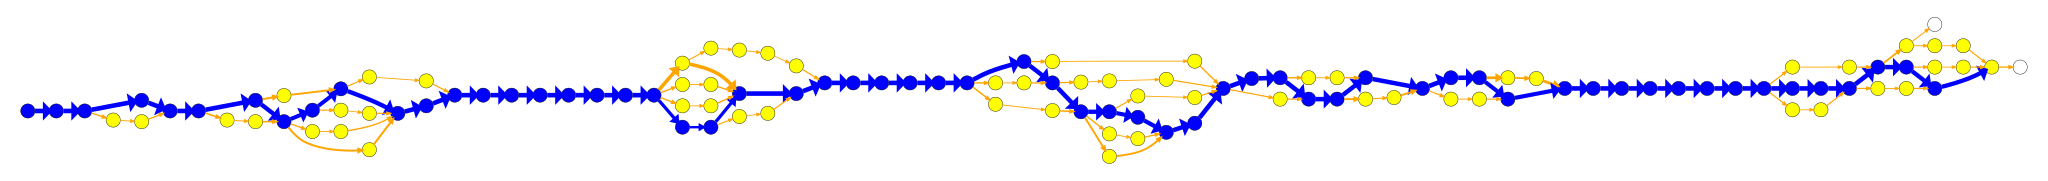

In [25]:
SVG("/results/KCNE1-128-32-8.svg")

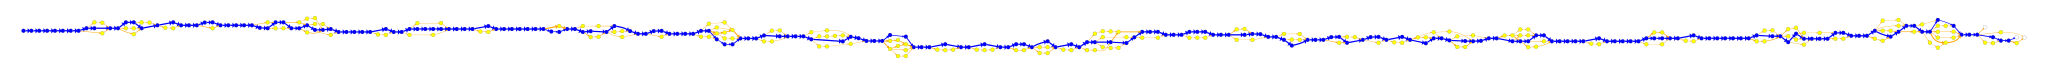

In [26]:
SVG("/results/KCNE1-128-32-4.svg")

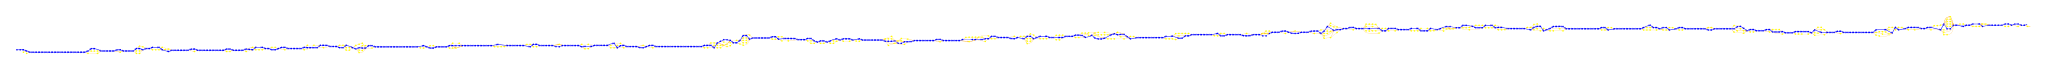

In [27]:
SVG("/results/KCNE1-128-32-2.svg")

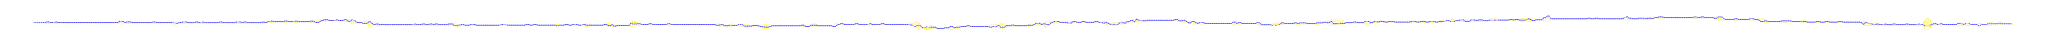

In [28]:
SVG("/results/KCNE1-128-32-1.svg")

Let's highlight a region of 12500 bases in the graph

In [29]:

roi_seq = gene_seq0[5000:17500]

In [30]:
#m_itvl = pgrtk.map_intervals_in_sdb(sdb, (10000, 10000+35883613-35883399) , exon_seq, 0.01)

In [31]:
seq_list2 = seq_list.copy()
seq_list2.insert(0, ("roi",roi_seq))


In [32]:
for r in (4,6,8):
    w=128; k=32;
    name="KCNE1_roi"
    G = get_graph(seq_list2, w=w, k=k, r=r, highlite=0)
    nx_pydot.write_dot(G, f"{name}-{w}-{k}-{r}.dot")
    ## for this version of graphviz, we need to create PDF to get the bounding box right
    os.system(f"""dot -Tpdf {name}-{w}-{k}-{r}.dot -x -Grankdir=LR -Gsize=64,64 \
    -Nfixedsize=true -Nwidth=.5 -Nheight=.5 -Nlabel="" > {name}-{w}-{k}-{r}.pdf""")
    os.system(f"""pdf2svg {name}-{w}-{k}-{r}.pdf {name}-{w}-{k}-{r}.svg""")

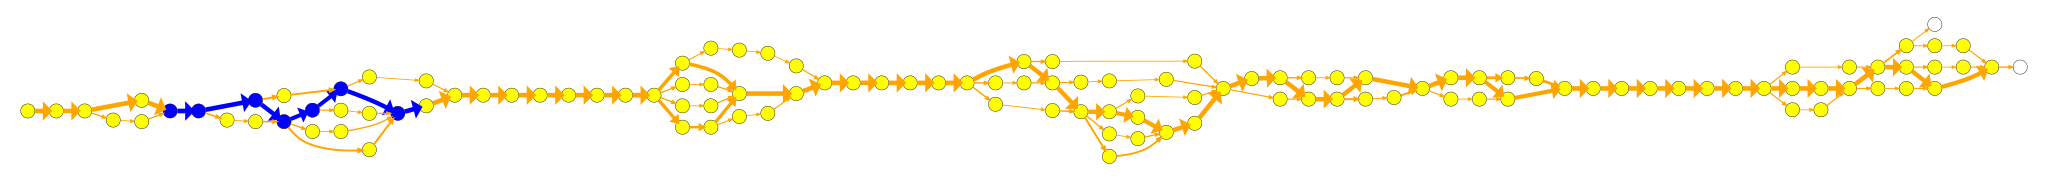

In [33]:
SVG("/results/KCNE1_roi-128-32-8.svg")

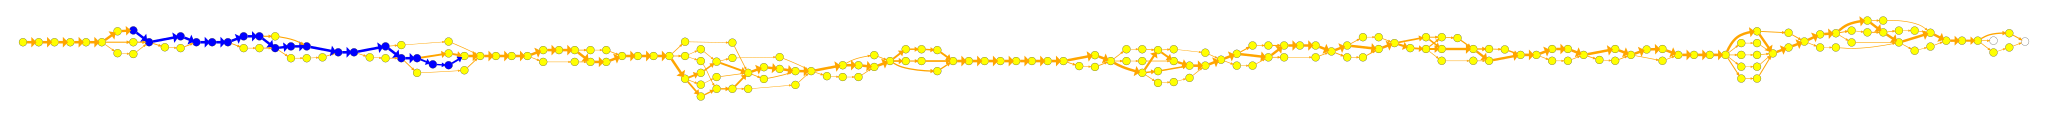

In [34]:
SVG("/results/KCNE1_roi-128-32-6.svg")

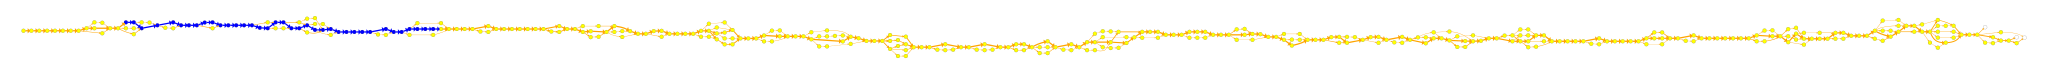

In [35]:
SVG("/results/KCNE1_roi-128-32-4.svg")